In [1]:
# -*- coding: utf-8 -*-
"""
2018-07-05 to 2018-07-12

Blinker analysis: Survey of QEs
Josh: search for the word "Josh" so you can adjust a few things.

@author: Viva R. Horowitz 
"""

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import seaborn as sns
import numpy as np
import sys
from IPython.display import display

sns.set(style='ticks')
#sns.set_context('poster')

%pylab inline
from matplotlib.mlab import frange

# ** set for each dataset
datadate = '2018-05-31_&_06-01'
datafolder = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\User\Viva\data'
analysisfolder = r'C:\Users\Viva\Documents\analysis\blinker_analysis\survey' ## Josh, give folder where you want to save graphs.

filenames = [r'2018-05-31_blinking-statistics\PLvstime04-20-2018.02,00pm.FIBedhBN.txt',
             r'2018-05-31_blinking-statistics\PLvstime04-21-2018.03,00pm.FIBedhBN.txt',
             r'2018-07-13_blinking-statistics\07_ND2.0, right_candidate.txt',
             r'2018-06-01_blinking-statistics\FIBedhBN.04-22-2018.04,00pm\02.txt',
             r'2018-06-01_blinking-statistics\4-22-2018.7,00pm\4-22-2018.7,00pm,01.txt',
             r'2018-06-01_blinking-statistics\4-22-2018.11,00am\4-22-2018.11,00am, 06, ND2,0.txt',
             r'2018-05-31_blinking-statistics\04-21-2018.11,00am.FIBedhBN\03-45degreepolarization.txt',
             r'2018-07-17_blinking-statistics\03, ND2.0, coords( 3.87,-4.22), 5-22-2018.1200.FIBedhBN. removed beamsplitter',
             r'2018-07-17_blinking-statistics\04, ND2.0,5-22-2018.1600.FIBedhBN. removed beamsplitter']  
             
dataname = 'survey of QEs'
labellist = ['04-20-2018.02,00pm', '04-21-2018.03,00pm',
             '04-21-2018.10,00am', '04-22-2018.04,00pm',
             '4-22-2018.7,00pm', '4-22-2018.11,00am, ND2.0',
             '04-21-2018.11,00am', '5-22-2018.1200','5-22-2018.1600']

assert (len(filenames) ==len(labellist))

print(np.__version__)
print(sns.__version__)
print(pd.__version__)
print(mpl.__version__)
print(sys.version)

Populating the interactive namespace from numpy and matplotlib
1.10.4
0.8.0
0.20.3
2.1.0
2.7.14 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:34:40) [MSC v.1500 64 bit (AMD64)]


In [2]:
## Define helper functions


## https://stackoverflow.com/questions/32765333/how-do-i-replicate-this-matlab-function-in-numpy/32765547#32765547
def histc(X, bins):
    map_to_bins = np.digitize(X,bins)
    r = np.zeros(bins.shape)
    for i in map_to_bins:
        r[i-1] += 1
    return [r, map_to_bins]

def manualnorm(histdata, binwidth):
    return (1/(histdata.sum()*binwidth))*histdata

def arangebylength(start, step, length):
    return np.arange(start = start, stop=start+step*(length-.5), step = step )

# rebin: combine two rows into one. Another way to do this would be time averaging or smoothing.
def rebindata(data, colname, timecolname, verbose = True):
    first = 1 # this is a value that indicates if we're on the first (=1) or the second (-1) of a pair of two bins
    rebinvals = []

    if verbose:
        print('Before rebinning:')
        display(data.tail())
    for value in data[colname]:
        #print 'value: ' + str(value)
        if first == 1:
            prevval = value
        else:
            # calculate average of the two bins
            combined = (prevval + value) /2.0 
            rebinvals.append(combined)
            del prevval
        first = -1 * first
         
    timesetting = data[timecolname][1]-data[timecolname][0]
    rebintimes = arangebylength(start =0, step = timesetting*2, length = len(rebinvals) )
    datadict = {timecolname: rebintimes, colname: rebinvals}
    rebinneddata = pd.DataFrame( data = datadict)
    return rebinneddata

In [3]:
## Load data

os.chdir(datafolder)

tname = 'Time (s)'
PLname = 'PL Intensity (kCts/s)'

rebins_to_do = [1,1,0,1,0,1,1,1,1] # number of times to rebin. ** Currently aiming for 100 Hz or 125 Hz collection rate for all.
assert (len(rebins_to_do) == len(labellist))
titlenames = copy(labellist)
timesettings = [0.0] * len(filenames)
fps= [0.0] * len(filenames)

for i in range(len(filenames)):
    print(titlenames[i])
    data = pd.read_csv(filenames[i],
                       skiprows=1,
                       header=None,
                       sep='\t',
                       names=[tname + ' ' + str(labellist[i]),str(labellist[i])],
                       usecols=[0,1])
    #data = data.set_index(tname)
    #display(data.head())
    rebincount = 0
    
    origfilenames = filenames
    timecolname = tname + ' ' + str(labellist[i])
    for j in range(rebins_to_do[i]):
        data = rebindata(data, colname=str(labellist[i]), timecolname=timecolname)
        rebincount = rebincount + 1
        print('rebinning')
    timesettings[i] = data[timecolname][1]-data[timecolname][0]
    fps[i] = 1/timesettings[i]
    print('Effective collection rate: ' + str(fps[i]) + ' Hz')
    print('Time bin size: ' + str(timesettings[i]) + ' sec')
    titlenames[i] = labellist[i] + ', ' + str(fps[i]) + ' Hz'
    #print(titlenames[i]) 
    #plt.scatter(x=data['Time (s) ' + str(labellist[i])], y=str(labellist[i]),linewidth=0.3)
    """ # uncomment to display data
    data[str(labellist[i])].plot(linewidth=0.3) 
    plt.ylabel('photoluminescence (kCts/s)')
    plt.xlabel('Time(s)')
    plt.show()
    """
    
    print('\n')
    
    if i > 0:
        alldata = pd.concat([alldata,data], axis=1)
    else:
        alldata = data;        
 
## Remove time information from the data; it isn't necessary for plotting the histogram
strlabellist = labellist
data = alldata[strlabellist]
display(data.head())

dataname = dataname + '100 or 125 Hz' ## **
#filename = filename.replace('\\','-')
#origfilename = filename
os.chdir(analysisfolder)
today = datetime.date.isoformat(datetime.date.today())
if not os.path.exists('taken-' + datadate):
    os.makedirs('taken-' + datadate)
os.chdir('taken-' + datadate)

print('today: '+today)
print(os.getcwd())

04-20-2018.02,00pm
Before rebinning:


,"Time (s) 04-20-2018.02,00pm","04-20-2018.02,00pm"
74995,360.780,3.25
74996,360.784,3.75
74997,360.788,5.00
74998,360.792,6.25
74999,360.796,3.25


rebinning
Effective collection rate: 125.0 Hz
Time bin size: 0.008 sec


04-21-2018.03,00pm
Before rebinning:


,"Time (s) 04-21-2018.03,00pm","04-21-2018.03,00pm"
74995,419.632,32.25
74996,419.636,39.00
74997,419.640,37.25
74998,419.644,34.75
74999,419.648,35.00


rebinning
Effective collection rate: 125.0 Hz
Time bin size: 0.00800000000001 sec


04-21-2018.10,00am
Effective collection rate: 100.0 Hz
Time bin size: 0.01 sec


04-22-2018.04,00pm
Before rebinning:


,"Time (s) 04-22-2018.04,00pm","04-22-2018.04,00pm"
74994,346.952,34.25
74995,346.956,29.50
74996,346.960,31.75
74997,346.964,32.75
74998,346.968,30.75


rebinning
Effective collection rate: 125.0 Hz
Time bin size: 0.008 sec


4-22-2018.7,00pm
Effective collection rate: 100.0 Hz
Time bin size: 0.01 sec


4-22-2018.11,00am, ND2.0
Before rebinning:


,"Time (s) 4-22-2018.11,00am, ND2.0","4-22-2018.11,00am, ND2.0"
74994,338.836,25.75
74995,338.840,20.00
74996,338.844,22.00
74997,338.848,21.50
74998,338.852,23.75


rebinning
Effective collection rate: 125.0 Hz
Time bin size: 0.008 sec


04-21-2018.11,00am
Before rebinning:


,"Time (s) 04-21-2018.11,00am","04-21-2018.11,00am"
74994,309.432,30.25
74995,309.436,28.25
74996,309.440,28.25
74997,309.444,26.50
74998,309.448,34.75


rebinning
Effective collection rate: 125.0 Hz
Time bin size: 0.008 sec


5-22-2018.1200
Before rebinning:


,Time (s) 5-22-2018.1200,5-22-2018.1200
74994,384.870,23.8
74995,384.875,22.6
74996,384.880,26.4
74997,384.885,18.0
74998,384.890,21.2


rebinning
Effective collection rate: 100.0 Hz
Time bin size: 0.01 sec


5-22-2018.1600
Before rebinning:


,Time (s) 5-22-2018.1600,5-22-2018.1600
74994,384.055,8.4
74995,384.060,13.8
74996,384.065,8.2
74997,384.070,20.6
74998,384.075,6.8


rebinning
Effective collection rate: 100.0 Hz
Time bin size: 0.01 sec




,"04-20-2018.02,00pm","04-21-2018.03,00pm","04-21-2018.10,00am","04-22-2018.04,00pm","4-22-2018.7,00pm","4-22-2018.11,00am, ND2.0","04-21-2018.11,00am",5-22-2018.1200,5-22-2018.1600
0,6.125,37.500,33.4,45.375,17.8,23.000,5.625,20.3,5.4
1,3.750,29.500,27.4,32.625,18.4,27.500,9.250,23.2,12.4
2,5.125,31.125,28.7,35.500,15.6,29.000,8.250,23.4,9.5
3,3.625,29.625,31.6,35.625,12.4,26.750,9.250,19.2,15.0
4,4.250,30.500,30.3,34.500,19.2,27.375,8.000,22.0,20.3


today: 2018-07-17
C:\Users\Viva\Documents\analysis\blinker_analysis\survey\taken-2018-05-31_&_06-01


histdata initialized


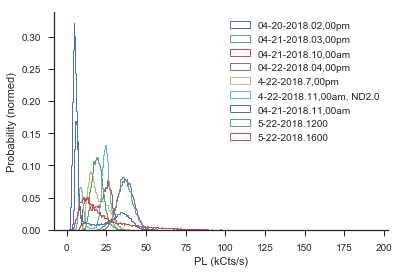

In [4]:
stepsize = .5 # Josh, you can change the size of the histogram bins here. 
             # If you look at the raw PL data (shown just above this in kCts/s), you can see how it varies.
             # The datasets don't all have the same resolution.


# adding a stepsize to the max is a workaround to a bug
binsequence= frange(min(data.min()),max(data.max())+stepsize,stepsize)

## Plot them all on the same axes (too hard to see it)

try:
    del histdata
    del newhistdata
except NameError:
    pass
#histdata=pd.DataFrame(columns=['QE', PLname, "Occurrences"])

for i in range(len(strlabellist)):
    thisdata = data[strlabellist[i]]
    plt.hist(thisdata[~np.isnan(thisdata)], bins=binsequence,  histtype='step', linewidth=1, label=strlabellist[i], density=True)
    newhistdata,_ = histc(thisdata[~np.isnan(thisdata)], bins=np.asarray(binsequence))
    labellisttemp = [labellist[i]] * len(binsequence)
    ## Norm the newhistdata
    #   adding a stepsize to the max was a workaround to a bug
    #   now we remove that last bin, which should have been empty (but it's so buggy it wasn't empty)
    newhistdatanormed = manualnorm(newhistdata[:-1], stepsize)
    
    try:
        # append histogram to dataframe histdata

        histdata = histdata.append(pd.DataFrame(transpose([labellisttemp[:-1], binsequence[:-1],newhistdatanormed.tolist()])))
#        print ("appended")
    except NameError:
        histdata = pd.DataFrame(transpose([labellisttemp[:-1], binsequence[:-1],newhistdatanormed.tolist()]))
        print( "histdata initialized")
histdata = histdata.rename(index=str, columns={0: 'QE', 1: PLname, 2:"Probability"})           
tabledata = histdata.pivot('QE', PLname, "Probability")



#sns.distplot(data[strlabellist[9]], bins=numbins, kde=True, rug=False, hist_kws={"histtype": "step", "linewidth": 1, "alpha": 1, "color": "k"});
plt.xlabel('PL (kCts/s)')
plt.ylabel('Probability (normed)')
#ax = plt.gca()
#ax.set_yscale('symlog', linthreshy=1)
#ax.set_xscale('log')
sns.despine()
plt.legend()
plt.show()


QEs:
0: 04-20-2018.02,00pm
1: 04-21-2018.03,00pm
2: 04-21-2018.10,00am
3: 04-22-2018.04,00pm
4: 4-22-2018.7,00pm
5: 4-22-2018.11,00am, ND2.0
6: 04-21-2018.11,00am
7: 5-22-2018.1200
8: 5-22-2018.1600

today: 2018-07-17
C:\Users\Viva\Documents\analysis\blinker_analysis\survey\taken-2018-05-31_&_06-01
save file: 2018-07-17,survey of QEs100 or 125 Hz,PLvspowerhists-nopeaks


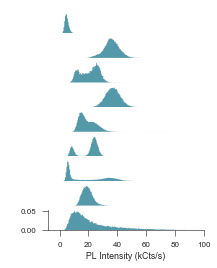

In [5]:
#sns.set_context('talk')
#sns.set_style('ticks')
sns.set(style='ticks',rc={'axes.linewidth':0.6})
sns.set_context('paper',rc={'xtick.major.width':0.6,'ytick.major.width':0.6})
sns.set_palette(sns.husl_palette(1,h=0.6,l=0.6,s=0.7))

os.chdir(analysisfolder)
today = datetime.date.isoformat(datetime.date.today())
if not os.path.exists('taken-' + datadate):
    os.makedirs('taken-' + datadate)
os.chdir('taken-' + datadate)



peaksPL = {labellist[0]:None}
peaksprob = {labellist[0]:None}

print("QEs:")

made_ylabel=False
plt.figure(figsize=(2.8,4)) # Josh, you may want a different figure size.
title(dataname)
for i in range(len(strlabellist)):
    print (str(i) + ': ' + strlabellist[i])
    ax = plt.subplot(len(strlabellist), 1, i+1)
    thisdata = data[strlabellist[i]]

    # Calculate and plot histograms
    hist(thisdata[~np.isnan(thisdata)],
                          bins=binsequence, # color = 'k',
                          histtype = 'stepfilled',  
                          # kde_kws={'bw':bw},
                          label='QE ' + strlabellist[i],
                          density=True)
    
    # Josh, I set some parameters for the graphs here.
    sns.despine(offset=0)
    xlim(xmax = 100) 
    if i<len(strlabellist)-1:
        ax.set_xticks([]) # no x ticks or labels
        plt.axis('off', which='x') # no axes
    
    # I don't know how to make just one ylabel so here's a terrible hack.
    if made_ylabel == False:
        if i >= 0.499 * (len(strlabellist)-1):
            ylabel('Probability')
            #print('Made ylabel')
            made_ylabel = True

xlabel("PL Intensity (kCts/s)");

#suptitle(dataname)
print('\ntoday: '+today)
print (os.getcwd())
print('save file: ' +today + ',' + dataname+',PLvspowerhists-nopeaks' )
plt.savefig(today + ',' + dataname+',PLvspowerhists-nopeaks.pdf', bbox_inches='tight')
plt.savefig(today + ',' + dataname+',PLvspowerhists-nopeaks.svg', bbox_inches='tight')
plt.savefig(today + ',' + dataname+',PLvspowerhists-nopeaks.png', bbox_inches='tight', dpi=600)

0: 04-20-2018.02,00pm
1: 04-21-2018.03,00pm
2: 04-21-2018.10,00am
3: 04-22-2018.04,00pm
4: 4-22-2018.7,00pm
Made ylabel
5: 4-22-2018.11,00am, ND2.0
6: 04-21-2018.11,00am
7: 5-22-2018.1200
8: 5-22-2018.1600


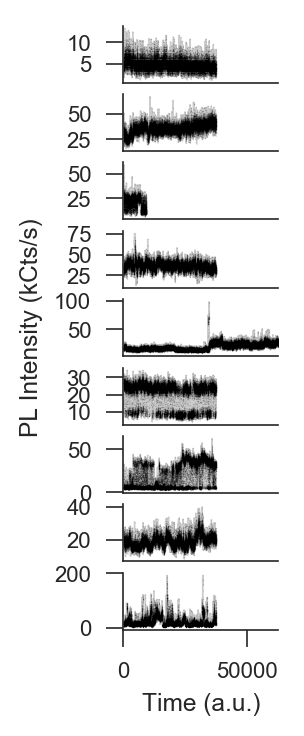

In [6]:
## Plot PL trajectories. Could use the alldata dataframe instead if I wanted to include time correctly.

fig = plt.figure(figsize=(1,4), dpi = 200)
#title(dataname)
made_ylabel = False
for i in range(len(strlabellist)):
    print (str(i) + ': ' + strlabellist[i])
    ax = fig.add_subplot(len(strlabellist), 1, i+1)
    thisdata = data[strlabellist[i]]
    thisdata.plot(marker='.', markersize=1,linestyle='None',legend=False, ax=ax, color='k',  alpha=.1)
    thisdata.plot(legend=False, linewidth=0.5, alpha=0.2, ax=ax, color='k')
    #legend()
    
    sns.despine()
    if i<len(strlabellist)-1:
        ax.set_xticks([])
    
    if made_ylabel == False:
        if i >= 0.5 * len(strlabellist)-1:
            ylabel(PLname)
            print('Made ylabel')
            made_ylabel = True

xlabel('Time (a.u.)');
#suptitle(dataname);

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


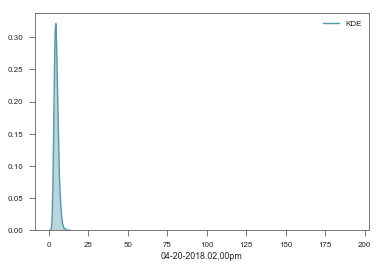

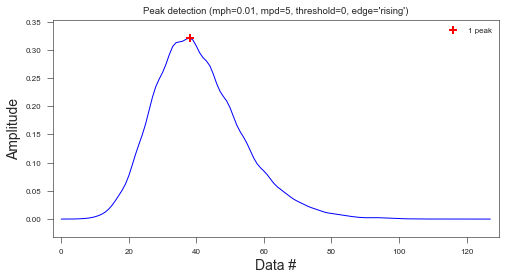

In [7]:
## Extract the peaks of these data
# https://stackoverflow.com/questions/37374983/get-data-points-from-seaborn-distplot

sys.path.append(r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\User\Viva\analysis\downloaded')
import detect_peaks
## http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
from detect_peaks import detect_peaks

i = 0

# bw = bandwidth for calculating kde
#bw = 1
# mph = minimum peak height
mph = .01
# mpd = minimum peak distance
mpd = 5

plt.figure()
output1 = sns.distplot(data[strlabellist[i]],bins=binsequence,kde_kws={'label':'KDE'},).get_lines()[0].get_data()

## http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb



ind= detect_peaks(output1[1], valley=False, show=True, mph=mph, mpd=mpd)
#print ind

"""
figure()
plot(output1[0], output1[1])
plot(output1[0][ind], output1[1][ind], 'r.')
output1[0][ind]
""";

today: 2018-07-17
C:\Users\Viva\Documents\analysis\blinker_analysis\survey\taken-2018-05-31_&_06-01
0: 04-20-2018.02,00pm
1: 04-21-2018.03,00pm
2: 04-21-2018.10,00am
3: 04-22-2018.04,00pm
4: 4-22-2018.7,00pm
Made ylabel
5: 4-22-2018.11,00am, ND2.0
6: 04-21-2018.11,00am
7: 5-22-2018.1200
8: 5-22-2018.1600
saved as: 2018-07-17,survey of QEs100 or 125 Hz,PLvspowerhists


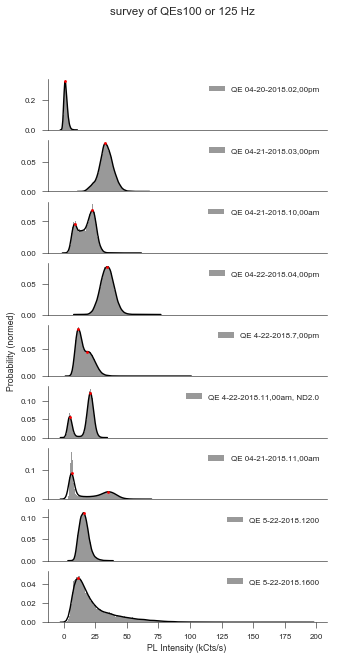

In [8]:
#sns.set_context('poster')


os.chdir(analysisfolder)
today = datetime.date.isoformat(datetime.date.today())
if not os.path.exists('taken-' + datadate):
    os.makedirs('taken-' + datadate)
os.chdir('taken-' + datadate)

print('today: '+today)
print (os.getcwd())

peaksPL = {labellist[0]:None}
peaksprob = {labellist[0]:None}

made_ylabel=False
plt.figure(figsize=(5,10))
title(dataname)
for i in range(len(strlabellist)):
    print (str(i) + ': ' + strlabellist[i])
    ax = plt.subplot(len(strlabellist), 1, i+1)
    # Calculate and plot histograms
    output = sns.distplot(data[strlabellist[i]],
                          bins=binsequence, color = 'k',
        #                  kde_kws={'bw':bw},
                          label='QE ' + strlabellist[i],).get_lines()[0].get_data()
    ind= detect_peaks(output[1], valley=False, show=False, mph=mph, mpd=mpd)
    ax.plot(output[0][ind], output[1][ind], 'r.')
    # record these peaks
    peaksPL[labellist[i]] = output[0][ind]
    peaksprob[labellist[i]] =output[1][ind]
    legend()
    xlabel(' ')
    sns.despine()
    
    if i<len(strlabellist)-1:
        ax.set_xticks([]) # no ticks or labels
    
    if made_ylabel == False:
        if i >= 0.5 * len(strlabellist)-1:
            ylabel('Probability (normed)')
            print('Made ylabel')
            made_ylabel = True

xlabel(PLname);

suptitle(dataname)
print('saved as: ' + today + ',' + dataname+',PLvspowerhists')
plt.savefig(today + ',' + dataname+',PLvspowerhists.pdf', bbox_inches='tight')
plt.savefig(today + ',' + dataname+',PLvspowerhists.png', bbox_inches='tight', dpi=200)

plt.show()

In [9]:
peaksPL

{'04-20-2018.02,00pm': array([ 4.63917713]),
 '04-21-2018.03,00pm': array([ 35.32044692]),
 '04-21-2018.10,00am': array([ 12.27251467,  25.45342477]),
 '04-21-2018.11,00am': array([  6.08579714,  34.44630968]),
 '04-22-2018.04,00pm': array([ 36.89463759]),
 '4-22-2018.11,00am, ND2.0': array([  8.31372066,  24.03921788]),
 '4-22-2018.7,00pm': array([ 14.81668748,  21.57707981]),
 '5-22-2018.1200': array([ 18.92565139]),
 '5-22-2018.1600': array([ 11.48517725])}

In [10]:
peaksprob

{'04-20-2018.02,00pm': array([ 0.321124]),
 '04-21-2018.03,00pm': array([ 0.08142564]),
 '04-21-2018.10,00am': array([ 0.0459325 ,  0.06790989]),
 '04-21-2018.11,00am': array([ 0.08927438,  0.0256374 ]),
 '04-22-2018.04,00pm': array([ 0.07738885]),
 '4-22-2018.11,00am, ND2.0': array([ 0.05688068,  0.12171316]),
 '4-22-2018.7,00pm': array([ 0.08747167,  0.04550904]),
 '5-22-2018.1200': array([ 0.11100837]),
 '5-22-2018.1600': array([ 0.04641408])}

In [11]:
histdata.head()

,QE,PL Intensity (kCts/s),Probability
0,"04-20-2018.02,00pm",1.25,0.000853333333333
1,"04-20-2018.02,00pm",1.75,0.00714666666667
2,"04-20-2018.02,00pm",2.25,0.0357866666667
3,"04-20-2018.02,00pm",2.75,0.10016
4,"04-20-2018.02,00pm",3.25,0.198026666667


In [12]:
labellist

['04-20-2018.02,00pm',
 '04-21-2018.03,00pm',
 '04-21-2018.10,00am',
 '04-22-2018.04,00pm',
 '4-22-2018.7,00pm',
 '4-22-2018.11,00am, ND2.0',
 '04-21-2018.11,00am',
 '5-22-2018.1200',
 '5-22-2018.1600']

In [13]:
tabledata

PL Intensity (kCts/s),1.25,1.75,10.25,10.75,100.25,100.75,101.25,101.75,102.25,102.75,...,95.25,95.75,96.25,96.75,97.25,97.75,98.25,98.75,99.25,99.75
QE,,,,,,,,,,,,,,,,,,,,,
"04-20-2018.02,00pm",0.000853333333333,0.00714666666667,0.00224,0.00112,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"04-21-2018.03,00pm",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"04-21-2018.10,00am",0.0,0.0,0.0409475828063,0.0463072140637,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"04-21-2018.11,00am",0.0,0.0,0.0109869596523,0.0123736632977,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"04-22-2018.04,00pm",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"4-22-2018.11,00am, ND2.0",0.0,0.0,0.029120776554,0.0195205205472,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"4-22-2018.7,00pm",0.0,0.0,0.0109533210215,0.0196459275298,0.0,0.0,0.0,0.0,0.0,0.0,...,3.1841049481e-05,0.0,0.0,3.1841049481e-05,0.0,0.0,3.1841049481e-05,0.0,0.0,0.0
5-22-2018.1200,0.0,0.0,0.000586682311528,0.00197338595696,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5-22-2018.1600,0.0,0.0,0.0512013653697,0.0453345422545,0.000106669511187,0.000106669511187,0.00016000426678,0.00016000426678,0.000213339022374,0.000266673777967,...,0.000266673777967,0.00016000426678,0.00016000426678,0.000426678044748,0.000106669511187,0.000266673777967,0.00016000426678,0.000266673777967,0.000266673777967,5.33347555935e-05


In [14]:
#transpose(tabledata)